# Model Inference

## Import modules

In [1]:
from colr import color
import os 
import glob as glob
import pathlib

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import regularizers

from PIL import Image , ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Inference class

In [2]:
class ImageMarker():
    """
    Class to perform image segmantation on raw images.

    Parameters
    ----------
    model_path : string
        Tells the class where the tf.lite model is stored.
    width : int
        Tells the class the width of the input the tf.lite
        model was trained on (default: 320).
    height: int
        Tells the class the height of the input the tf.lite
        model was trained on (default: 224).       
    """
    
    def __init__(self, model_path: str, width: int = 320, height: int = 224):
        # Set model path
        if not isinstance(model_path, str):
            raise TypeError("model_path must be a string")
        else:      
            self.set_model(model_path)
            
        # Set width
        if not isinstance(width, int):
            raise TypeError("width must be a int")
        else:      
            self.width = width
            
        # Set height
        if not isinstance(height, int):
            raise TypeError("height must be a int")
        else:      
            self.height = height
            
        # VOC 2012 dataset fields 
        self.N_CLASSES = 21
        self.VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]
        self.VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']
    
    def set_model(self, model_path: str):
        """Set tf.lite interpreter class."""
        # Set tf.lite model to interpreter
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()

        # Get input and output tensors.
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        
    def shade_img(self, yh_mask: np.array):
        # Get pred classes
        yh_unique = np.unique(yh_mask)
        classes_found = []
        for c in yh_unique.tolist():
            classes_found.append(self.VOC_CLASSES[c])
            
        # Get colors
        colors = []
        colors = [self.VOC_COLORMAP[i] for i in yh_unique]
        
        # Make color mask
        color_mask = np.reshape(yh_mask,(self.width,self.height,1))
        color_mask = np.concatenate((color_mask, color_mask, color_mask), axis=-1)
        print(color_mask.shape)
        for i, c in enumerate(yh_unique.tolist()):
            # Change r-val
            color_mask[:,:,0] = np.where(color_mask[:,:,0] == c, self.VOC_COLORMAP[c][0], color_mask[:,:,0])
            # Change g-val
            color_mask[:,:,1] = np.where(color_mask[:,:,1] == c, self.VOC_COLORMAP[c][1], color_mask[:,:,1])
            # Change b-val
            color_mask[:,:,2] = np.where(color_mask[:,:,2] == c, self.VOC_COLORMAP[c][2], color_mask[:,:,2])
            
        return color_mask, classes_found, colors
        
    def __call__(self, data: np.array, color_img: bool = False) -> np.array:
        """ Infer mask for passed image data."""
        # Set image data
        sample_img = data/255.0
        sample_img = sample_img.reshape(1,self.width,self.height,3)
        sample_img_tensor = tf.convert_to_tensor(sample_img, dtype='float32')
        self.interpreter.set_tensor(self.input_details[0]['index'], sample_img_tensor)
        self.interpreter.invoke()
        
        # Get model output for set data
        yh = self.interpreter.get_tensor(self.output_details[0]['index'])
        yh = yh*255.0
        yh = yh.astype('int')
        yh_mask = np.argmax(yh[0,:,:,:],axis=-1)
        
        if color_img == True:
            color_mask, pred_classes, colors = self.shade_img(yh_mask)
            return yh_mask, color_mask, pred_classes, colors
        else:    
            return mask, None, None, None


## Declare inference model and load ResNetFCN

In [3]:
model_path = "f16_lite_model/ResNetFCN_VOC2012_f16.tflite"
model = ImageMarker(model_path)

## Test on image

(224, 320, 3)


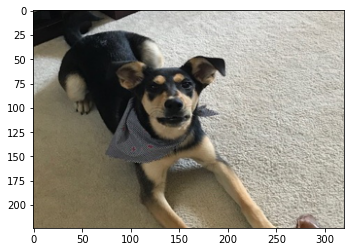

In [4]:
pic_path = "test_pic.jpg"
test_pic = Image.open(pic_path)
test_pic = test_pic.resize((320,224)) 
test_pic = np.array(test_pic)
plt.imshow(test_pic)
print(test_pic.shape)

In [5]:
test_pic = np.transpose(test_pic, (1,0,2))
yh_mask, color_mask, classes_found, colors = model(test_pic, color_img=True)

(320, 224, 3)


Predicted classes and colors:
	 Class: background
	 Class: dog
	 Class: person


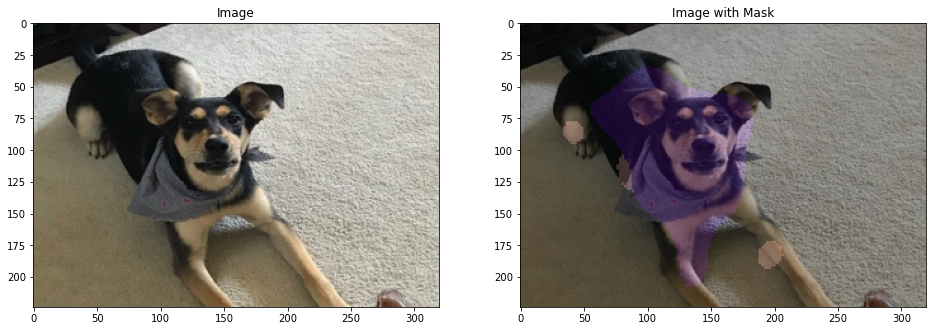

In [6]:
def plotImgMask(pic_path, color_mask, classes_found, colors):
    test_pic = Image.open(pic_path)
    test_pic = test_pic.resize((320,224)) 
    test_pic = np.array(test_pic)

    fig=plt.figure(figsize=(16, 16))
    columns = 2
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        if i == 1:
            img = test_pic
            img = Image.fromarray(img,'RGB')
            plt.imshow(np.array(img))
            plt.title('Image')
        elif i == 2:
            plt.imshow(test_pic)
            plt.imshow(np.transpose(color_mask, (1,0,2)), alpha=0.3)
            plt.title('Image with Mask')

    # Check predicted unique classes
    print("Predicted classes and colors:")
    for i, c in enumerate(classes_found):
        print("\t Class: " + color(c, fore=colors[i], back=(255, 255, 255)))
        
plotImgMask(pic_path, color_mask, classes_found, colors)